![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Clustering using Disjunctive Constraints

[K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is one of the most used clustering problems in unsupervised learning. Typically, a heuristic algorithm is used to solve the K-Means clustering problem. Such algorithms however do not guarantee a global optimum. In this notebook, we show how K-Means can be expressed as a Generalized Disjunctive Program (GDP) with a Quadratic Rotated Cone, and we demonstrate how to implement it in MOSEK using Disjunctive Constraints (DJC). Such problem was for example studied by [Papageorgiou, Trespalacios](https://link.springer.com/article/10.1007/s13675-017-0088-0) and [Kronqvist, Misener, Tsay](https://link.springer.com/chapter/10.1007/978-3-030-78230-6_19). We further show a modification called Euclidean clustering by changing only a few lines of code. 

We assume a set of points $\textbf{p}_1, \ldots, \textbf{p}_n \in \mathbb{R}^\mathcal{D}$ and a natural number $\mathcal{K} \in \{1, 2, ..., n\}$ which specifies number of centroids. We want to find positions of the centroids such that the overall squared Euclidean distance from each point to the closest centroid is minimized. The formulation using disjunctions can look as follows

$$\begin{array}{rll}
\text{minimize} & \sum_{i=1}^n d_i & \\
\text{subject to} & \bigvee_{j \in \{1, .., \mathcal{K}\}} \Bigl[ d_i \geq || \textbf{c}_j - \textbf{p}_i ||_2^2  \wedge Y_i = j \Bigr], & \forall i \in \{1, ..., n\},\\
& c_{j-1, 1} \leq c_{j, 1}, & \forall j \in \{2, .., \mathcal{K}\},\\
\\
& d_1, ..., d_n \in \mathbb{R}, & \\
& \textbf{c}_1, ..., \textbf{c}_{\mathcal{K}} \in \mathbb{R}^\mathcal{D}, \\
& Y_1, ..., Y_n \in \{1, .., \mathcal{K}\}, &
\end{array}$$

where $\textbf{c}_1, ..., \textbf{c}_{\mathcal{K}}$ are the positions of the centroids, $d_1, ..., d_n$ are auxiliary variables representing the shortest squared distance to the nearest centroid for each point and $Y_1, ..., Y_n$ are classification labels for each point, indicating the index of the nearest centroid. The first constraint is a disjunctive constraint representing the choice of a centroid for each point. Exactly one of the clauses in each of $n$ disjunctions is "active" and determines the index of the nearest centroid and the distance to is. The second constraint in the formulation is a symmetry-breaking constraint. 

**MOSEK** only supports Disjunctive Normal Form (DNF) of affine constraints. Formally, this means that each Disjunctive Constraint (DJC) is of the form $ \bigvee_i \bigwedge_j T_{i, j}$, where $T_{i,j}$ is an affine constraint. Such constraint is satisfied if and only if there exists at least one term $i$, such that all affine constraints $T_{i,j}$ are satisfied. We therefore need to move the non-linearity out of the disjunction. This can be tackled by a using new auxiliary variables $dAux_{i, j}$ and constraining them outside of the dicjunctions. The program then looks in the following way: 

$$\begin{array}{rll}
\text{minimize} & \sum_{i=1}^n d_i & \\
\text{subject to} & \bigvee_{j \in \{1, .., \mathcal{K}\}} \Bigl[ d_i \geq dAux_{i, j} \wedge \hspace{0.2cm} Y_i = j \Bigr], & \forall i \in \{1, ..., n\},\\
& dAux_{i, j} \geq || \textbf{c}_j - \textbf{p}_i ||_2^2, & \forall j \in \{1, .., \mathcal{K}\}, \forall i \in \{1, ..., n\} \\
& c_{j-1, 1} \leq c_{j, 1}, & \forall j \in \{2, .., \mathcal{K}\}, \\
\\
& dAux \in \mathbb{R}^{n \times \mathcal{K}}, &  \\
& d_1, ..., d_n \in \mathbb{R}, & \\
& \textbf{c}_1, ..., \textbf{c}_{\mathcal{K}} \in \mathbb{R}^\mathcal{D}, & \\
& Y_1, ..., Y_n \in \{1, .., \mathcal{K}\}. &
\end{array}$$

### Preparing synthetic data

To prepare the synthetic data, we generate 3 clusters with the same number of points. These clusters are generated randomly according to the Multivariate normal distribution each with an appropriate mean vector and a covariance matrix. 

In [1]:
import numpy as np
from mosek.fusion import *
import matplotlib.pyplot as plt
import sys

# make the randomness deterministic
np.random.seed(0)

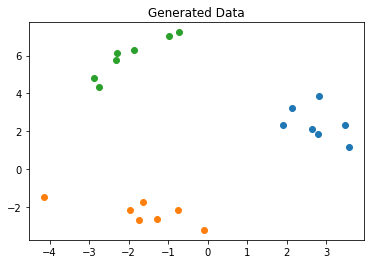

In [2]:
# specify the number of points
nData = 21

# generate data
numberOfClusters = 3
size = nData // numberOfClusters

pointsClass1 = np.random.multivariate_normal(np.array([1, 1])*2, np.array([[1, 0], [0, 1]])*0.7, size=size)
pointsClass2 = np.random.multivariate_normal(np.array([-1, -1])*2, np.array([[1, 0], [0, 1]])*0.7, size=size)
pointsClass3 = np.random.multivariate_normal(np.array([-1, 3])*2, np.array([[1, 0], [0, 1]])*0.7, size=size)

points = np.vstack((pointsClass1, pointsClass2, pointsClass3))

# plot the generated data

labels = np.zeros(3*size)
labels[size:2*size] = 1
labels[2*size:] = 2

plt.title("Generated Data")
plt.scatter(pointsClass1[:, 0], pointsClass1[:, 1])
plt.scatter(pointsClass2[:, 0], pointsClass2[:, 1])
plt.scatter(pointsClass3[:, 0], pointsClass3[:, 1])
plt.show()


### Fusion Model
In the following block, we show the K-Means model in the **Mosek Fusion for Python** in a vectorized fashion.

In [3]:
# get shape
n, d = points.shape

xs = np.repeat( points, numberOfClusters, axis=0)

# create model
with Model() as M: 

    ########## create variables ##########

    centroids = M.variable( [numberOfClusters, d], Domain.unbounded() )

    distances = M.variable( n, Domain.greaterThan(0) )
    distanceAux = M.variable( [n, numberOfClusters] , Domain.greaterThan(0) )

    # create classification labels
    Y = M.variable( n, Domain.integral( Domain.inRange(0, numberOfClusters-1) ) )


    ########## create constraints ##########

    # quadratic cone constraints
    a1 = Expr.flatten( distanceAux )
    a2 = Expr.constTerm([n*numberOfClusters, 1], 0.5)
    a3 = Expr.sub(  Expr.repeat(centroids, n, 0) , xs )
    
    hstack = Expr.hstack([a1, a2, a3])                      # ( d_{ij}Aux, 1/2, x_i - c_j ) in Qr
    M.constraint( hstack, Domain.inRotatedQCone() )

    # create disjunctive constraints
    for pointInd in range(0, n):
        label = Y.index(pointInd)
        di = distances.index(pointInd)

        ANDs = {}

        # create AND constraints
        for clusterInd in range(0, numberOfClusters):
            dijAux = distanceAux.index([pointInd, clusterInd])

            ANDs[clusterInd] = DJC.AND( DJC.term( Expr.sub(di, dijAux),Domain.greaterThan(0)),   # di >= dijAux
                                        DJC.term( label , Domain.equalsTo(clusterInd)       ))   # Y_i = j
        
        M.disjunction( [ ANDs[i] for i in range(0, numberOfClusters) ] )


    # symmetry breaking constraints
    M.constraint( Expr.sub(centroids.slice([0, 0], [numberOfClusters-1, 1]), 
                           centroids.slice([1, 0], [numberOfClusters, 1])), Domain.lessThan(0) )

    ########## solve ##########

    M.objective( ObjectiveSense.Minimize, Expr.sum(distances) )        

    M.setLogHandler(sys.stdout)     # Enable log output

    # Solve 
    M.solve()

    # get centroids and clusters
    labels_KMEANS = Y.level()
    centroids_KMEANS = np.array(centroids.level()).reshape(numberOfClusters, d)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2               
  Affine conic cons.     : 63              
  Disjunctive cons.      : 21              
  Cones                  : 0               
  Scalar variables       : 112             
  Matrix variables       : 0               
  Integer variables      : 21              

Optimizer started.
Mixed integer optimizer started.
Threads used: 64
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 420 variables, 290 constraints, 664 non-zeros
Presolved problem: 21 general integer, 63 binary, 336 continuous
Presolved problem: 63 cones
Presolved problem: 63 disjunctions
Clique table size: 63
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   0.0000000000e+00     N

### Plotting the results

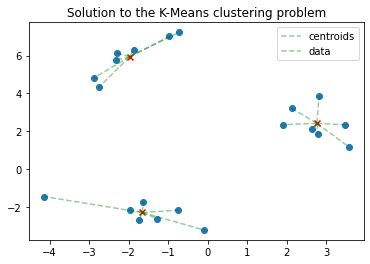

In [4]:
def plotTheResults(centroids, points, labels, kmeans=True):
    # scatter centroids and data
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='r')
    plt.scatter(points[:, 0], points[:, 1], marker='o')

    # draw lines to centroids
    for i in range(0, numberOfClusters):

        centroid = centroids[i, :]
        cluster = points[labels == i, :]
        nPointsInCluster = cluster.shape[0]

        centroidCopied = np.tile(centroid, (nPointsInCluster, 1))

        xx = np.vstack( [ centroidCopied[:, 0] , cluster[:, 0] ])
        yy = np.vstack( [ centroidCopied[:, 1] , cluster[:, 1] ])

        # plot the lines
        plt.plot(xx, yy, '--', color='green', alpha=0.4)


    # show the points
    if kmeans:
        plt.title("Solution to the K-Means clustering problem")
    else: 
        plt.title("Solution to the Euclidean clustering problem")
    
    plt.legend(["centroids", "data"])
    plt.show()

# call the function

plotTheResults(centroids_KMEANS, points, labels_KMEANS, kmeans=True)

## Euclidean Clustering

In order to change the proposed model to Euclidean Clustering, we need to only change the squared norm of the distances to standard Euclidean norm. This approach is more robust to outliers compared to the K-Means algorithm. Euclidean clustering problem has the following form:

$$\begin{array}{rll}
\text{minimize} & \sum_{i=1}^n d_i & \\
\text{subject to} & \bigvee_{j \in \{1, .., \mathcal{K}\}} \Bigl[ \hspace{0.2cm} d_i \geq dAux_{i, j} \wedge Y_i = j \Bigr], & \forall i \in \{1, ..., n\},\\
& dAux_{i, j} \geq || \textbf{c}_j - \textbf{p}_i ||_2, & \forall j \in \{1, .., \mathcal{K}\}, & \forall i \in \{1, ..., n\}, \\
& c_{j-1, 1} \leq c_{j, 1} , & \forall j \in \{2, .., \mathcal{K}\}, \\
\\
& dAux \in \mathbb{R}^{n \times \mathcal{K}}_+  & \\
& d_1, ..., d_n \in \mathbb{R}_{+}, & \\
& \textbf{c}_1, ..., \textbf{c}_{\mathcal{K}} \in \mathbb{R}^\mathcal{D}, & \\
& Y_1, ..., Y_n \in \{1, .., \mathcal{K}\}. &
\end{array}$$

Heuristic algorithms usually solve such a problem by finding a geometric median. In the **Fusion API** model, we need to only swap the Rotated Quadratic Cone for Quadratic Cone.


## Data

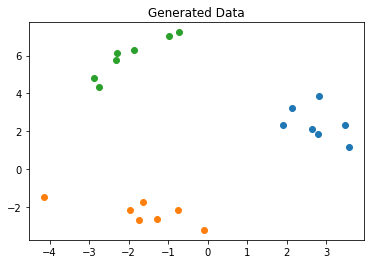

In [5]:
# use the same data

plt.title("Generated Data")
plt.scatter(pointsClass1[:, 0], pointsClass1[:, 1])
plt.scatter(pointsClass2[:, 0], pointsClass2[:, 1])
plt.scatter(pointsClass3[:, 0], pointsClass3[:, 1])
plt.show()

## Fusion Model

In [6]:
# get shape
n, d = points.shape

xs = np.repeat( points, numberOfClusters, axis=0)

# create model
with Model() as M: 

    ########## create variables ##########

    centroids = M.variable( [numberOfClusters, d], Domain.unbounded() )

    distances = M.variable( n, Domain.greaterThan(0) )
    distanceAux = M.variable( [n, numberOfClusters] , Domain.greaterThan(0) )

    # create classification labels
    Y = M.variable( n, Domain.integral( Domain.inRange(0, numberOfClusters-1) ) )


    ########## create constraints ##########

    # quadratic cone constraints - THIS IS THE ONLY DIFFERENCE TO K-MEANS MODEL
    a1 = Expr.flatten( distanceAux )
    a2 = Expr.sub(  Expr.repeat(centroids, n, 0) , xs )
    
    hstack = Expr.hstack([a1, a2])                      # ( d_{ij}Aux, x_i - c_j )
    M.constraint( hstack, Domain.inQCone() )            # now a quadratic instead of rotated quadratic cone

    # create disjunctive constraints
    for pointInd in range(0, n):
        label = Y.index(pointInd)
        di = distances.index(pointInd)

        ANDs = {}

        # create AND constraints
        for clusterInd in range(0, numberOfClusters):
            dijAux = distanceAux.index([pointInd, clusterInd])

            ANDs[clusterInd] = DJC.AND( DJC.term( Expr.sub(di, dijAux),Domain.greaterThan(0)),   # di >= dijAux
                                        DJC.term( label , Domain.equalsTo(clusterInd)       ))   # Y_i = j

        M.disjunction( [ ANDs[i] for i in range(0, numberOfClusters) ] )

    # symmetry breaking constraints
    M.constraint( Expr.sub(centroids.slice([0, 0], [numberOfClusters-1, 1]), 
                           centroids.slice([1, 0], [numberOfClusters, 1])), Domain.lessThan(0) )

    ########## solve ##########

    M.objective( ObjectiveSense.Minimize, Expr.sum(distances) )        

    M.setLogHandler(sys.stdout)     # Enable log output

    # Solve 
    M.solve()

    # get centroids and clusters
    labels_EUCL = Y.level()
    centroids_EUCL = np.array(centroids.level()).reshape(numberOfClusters, d)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2               
  Affine conic cons.     : 63              
  Disjunctive cons.      : 21              
  Cones                  : 0               
  Scalar variables       : 112             
  Matrix variables       : 0               
  Integer variables      : 21              

Optimizer started.
Mixed integer optimizer started.
Threads used: 64
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 357 variables, 290 constraints, 664 non-zeros
Presolved problem: 21 general integer, 63 binary, 273 continuous
Presolved problem: 63 cones
Presolved problem: 63 disjunctions
Clique table size: 63
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        1        0        NA                   0.0000000000e+00     N

### Plot the data

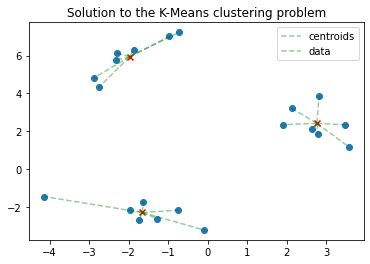

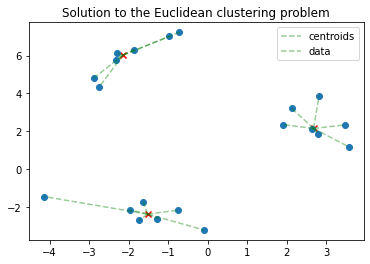

In [7]:
# call the plotting functions
plotTheResults(centroids_KMEANS, points, labels_KMEANS, kmeans=True)
plotTheResults(centroids_EUCL, points, labels_EUCL, kmeans=False)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 